## https://www.kaggle.com/sironghuang/understanding-pytorch-hooks

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch import tensor
from IPython.display import Image

In [2]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2,2)
        self.s1 = nn.Sigmoid()
        self.fc2 = nn.Linear(2,2)
        self.s2 = nn.Sigmoid()
        self.fc1.weight = torch.nn.Parameter(torch.Tensor([[0.15,0.2],[0.250,0.30]]))
        self.fc1.bias = torch.nn.Parameter(torch.Tensor([0.35]))
        self.fc2.weight = torch.nn.Parameter(torch.Tensor([[0.4,0.45],[0.5,0.55]]))
        self.fc2.bias = torch.nn.Parameter(torch.Tensor([0.6]))
        
    def forward(self, x):
        x= self.fc1(x)
        x = self.s1(x)
        x= self.fc2(x)
        x = self.s2(x)
        return x

In [3]:
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (s1): Sigmoid()
  (fc2): Linear(in_features=2, out_features=2, bias=True)
  (s2): Sigmoid()
)


In [4]:
# parameters: weight and bias
print(list(net.parameters()))
# input data
weight1 = list(net.parameters())[0]
weight2 = list(net.parameters())[2]
data = torch.Tensor([0.05,0.1])

[Parameter containing:
tensor([[0.1500, 0.2000],
        [0.2500, 0.3000]], requires_grad=True), Parameter containing:
tensor([0.3500], requires_grad=True), Parameter containing:
tensor([[0.4000, 0.4500],
        [0.5000, 0.5500]], requires_grad=True), Parameter containing:
tensor([0.6000], requires_grad=True)]


In [5]:
weight1, weight2

(Parameter containing:
 tensor([[0.1500, 0.2000],
         [0.2500, 0.3000]], requires_grad=True), Parameter containing:
 tensor([[0.4000, 0.4500],
         [0.5000, 0.5500]], requires_grad=True))

In [6]:
data.shape

torch.Size([2])

In [7]:
# output of last layer
out = net(data)
target = torch.Tensor([0.01,0.99])  # a dummy target, for example
criterion = nn.MSELoss()
loss = criterion(out, target); loss

tensor(0.2984, grad_fn=<MseLossBackward>)

In [8]:
# A simple hook class that returns the input and output of a
# layer during forward/backward pass

class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

In [9]:
net._modules.items()

odict_items([('fc1', Linear(in_features=2, out_features=2, bias=True)), ('s1', Sigmoid()), ('fc2', Linear(in_features=2, out_features=2, bias=True)), ('s2', Sigmoid())])

In [10]:
# register hooks on each layer
hookF = [Hook(layer[1]) for layer in list(net._modules.items())]
hookB = [Hook(layer[1],backward=True) for layer in
         list(net._modules.items())]

In [11]:
hookF

In [12]:
hookB

In [13]:
data

tensor([0.0500, 0.1000])

In [14]:
# run a data batch
out=net(data)
# backprop once to get the backward hook results
out.backward(torch.tensor([1,1],dtype=torch.float),retain_graph=True)

In [15]:
out

tensor([0.7514, 0.7729], grad_fn=<SigmoidBackward>)

In [16]:
print('***'*3+'  Forward Hooks Inputs & Outputs  '+'***'*3)
for hook in hookF:
    print(hook.input)
    print(hook.output)
    print('---'*17)
print('\n')
print('***'*3+'  Backward Hooks Inputs & Outputs  '+'***'*3)
for hook in hookB:             
    print(hook.input)          
    print(hook.output)         
    print('---'*17)

*********  Forward Hooks Inputs & Outputs  *********
(tensor([0.0500, 0.1000]),)
tensor([0.3775, 0.3925], grad_fn=<AddBackward0>)
---------------------------------------------------
(tensor([0.3775, 0.3925], grad_fn=<AddBackward0>),)
tensor([0.5933, 0.5969], grad_fn=<SigmoidBackward>)
---------------------------------------------------
(tensor([0.5933, 0.5969], grad_fn=<SigmoidBackward>),)
tensor([1.1059, 1.2249], grad_fn=<AddBackward0>)
---------------------------------------------------
(tensor([1.1059, 1.2249], grad_fn=<AddBackward0>),)
tensor([0.7514, 0.7729], grad_fn=<SigmoidBackward>)
---------------------------------------------------


*********  Backward Hooks Inputs & Outputs  *********
(tensor([0.0392, 0.0435]), tensor([0.0827]))
(tensor([0.0392, 0.0435]),)
---------------------------------------------------
(tensor([0.0392, 0.0435]),)
(tensor([0.1625, 0.1806]),)
---------------------------------------------------
(tensor([0.1868, 0.1755]), tensor([0.3623]))
(tensor([0.1868,

#### Forward calculations

In [17]:
torch.matmul(weight1, data) + 0.35

tensor([0.3775, 0.3925], grad_fn=<AddBackward0>)

In [18]:
weight1.shape, data.shape

(torch.Size([2, 2]), torch.Size([2]))

In [19]:
nn.Sigmoid()(tensor([0.3775, 0.3925]))

tensor([0.5933, 0.5969])

In [20]:
tensor([1/(1+np.exp(-x)) for x in [0.3775, 0.3925]])

tensor([0.5933, 0.5969])

In [21]:
torch.matmul(weight2, tensor([0.5933, 0.5969])) + 0.6

tensor([1.1059, 1.2249], grad_fn=<AddBackward0>)

In [22]:
tensor([1/(1+np.exp(-x)) for x in [1.1059, 1.2249]])

tensor([0.7514, 0.7729])

#### Backward calculations

In [23]:
# Confirm the calculations with the print result above
# the 4th layer - sigmoid
forward_output = np.array([0.7514, 0.7729]) 
grad_in = np.array([1,1])  # sigmoid layer
# grad of sigmoid(x) wrt x is: sigmoid(x)(1-sigmoid(x))
grad_out = grad_in*(forward_output*(1-forward_output)); grad_out 

array([0.18679804, 0.17552559])

In [24]:
# the 3th layer - linear
print([0.1868, 0.1755])  # grad_input * (grad of Wx+b = (w1*x1+w2*x2)+b wrt W) 
print(0.1868 + 0.1755)   # grad of Wx+b wrt b o

grad_in = torch.Tensor(grad_out)
grad_out = grad_in.view(1,-1) @ weight2;grad_out

[0.1868, 0.1755]
0.36229999999999996


tensor([[0.1625, 0.1806]], grad_fn=<MmBackward>)

In [25]:
class Guided_backprop():
    """
        Visualize CNN activation maps with guided backprop.
        
        Returns: An image that represent what the network learnt for recognizing 
        the given image. 
        
        Methods: First layer input that minimize the error between the last layers output,
        for the given class, and the true label(=1). 
        
        ! Call visualize(image) to get the image representation
    """
    def __init__(self,model):
        self.model = model
        self.image_reconstruction = None
        self.activation_maps = []
        # eval mode
        self.model.eval()
        self.register_hooks()
    
    def register_hooks(self):
        
        def first_layer_hook_fn(module, grad_out, grad_in):
            """ Return reconstructed activation image"""
            self.image_reconstruction = grad_out[0] 
            
        def forward_hook_fn(module, input, output):
            """ Stores the forward pass outputs (activation maps)"""
            self.activation_maps.append(output)
            
        def backward_hook_fn(module, grad_out, grad_in):
            """ Output the grad of model output wrt. layer (only positive) """
            
            # Gradient of forward_output wrt. forward_input = error of activation map:
                # for relu layer: grad of zero = 0, grad of identity = 1
            grad = self.activation_maps[-1] # corresponding forward pass output 
            grad[grad>0] = 1 # grad of relu when > 0
            
            # set negative output gradient to 0 #!???
            positive_grad_out = torch.clamp(input=grad_out[0],min=0.0)
            
            # backward grad_out = grad_out * (grad of forward output wrt. forward input)
            new_grad_out = positive_grad_out * grad
            
            del self.forward_outputs[-1] 
            
            # For hook functions, the returned value will be the new grad_out
            return (new_grad_out,)
            
        # !!!!!!!!!!!!!!!! change the modules !!!!!!!!!!!!!!!!!!
        # only conv layers, no flattened fc linear layers
        modules = list(self.model._modules.items())
        
        # register hooks to relu layers
        for name, module in modules:
            if isinstance(module, nn.ReLU):
                module.register_forward_hook(forward_hook_fn)
                module.register_backward_hook(backward_hook_fn)
        
        # register hook to the first layer 
        first_layer = modules[0][1] 
        first_layer.register_backward_hook(first_layer_hook_fn)
        
    def visualize(self, input_image, target_class):
        # last layer output
        model_output = self.model(input_image)
        self.model.zero_grad()
        
        # only calculate gradients wrt. target class 
        # set the other classes to 0: eg. [0,0,1]
        grad_target_map = torch.zeros(model_output.shape,
                                     dtype=torch.float)
        grad_target_map[0][target_class] = 1
        
        model_output.backward(grad_target_map)
        
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        result = self.image_reconstruction.data.numpy()[0] 
        return result

In [26]:
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

model = nn.Sequential(
    nn.Linear(10, 25),
    nn.ReLU(),
    nn.Linear(25, 2)
)

In [27]:
model.parameters

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=10, out_features=25, bias=True)
  (1): ReLU()
  (2): Linear(in_features=25, out_features=2, bias=True)
)>

In [28]:
weights = model[0].weight.data.numpy()
weights

array([[ 0.05605903,  0.21413276,  0.03864008,  0.27759585, -0.0218803 ,
        -0.27770042, -0.12772922,  0.21790203,  0.27921847,  0.17068928],
       [ 0.2353166 , -0.30308807,  0.00965044, -0.05414191,  0.26118025,
         0.22667179,  0.15487832,  0.07039323, -0.24430089, -0.13256349],
       [ 0.02279872,  0.17414159, -0.01550066,  0.16892502, -0.27508423,
         0.09690019,  0.09893283,  0.28091332, -0.30712515,  0.2810661 ],
       [ 0.28747836, -0.18949239, -0.09113134,  0.09072161, -0.24991967,
        -0.07525887,  0.3030893 , -0.2875347 ,  0.1885108 ,  0.06511906],
       [ 0.20232043,  0.31575915, -0.11479175,  0.30545577, -0.02487636,
         0.2835237 , -0.22868106, -0.10547651,  0.24900278, -0.2795855 ],
       [-0.02803028, -0.20272726,  0.12217557, -0.26757693, -0.28732404,
        -0.21200514,  0.29561362, -0.23897329, -0.02601784, -0.00986987],
       [ 0.1934112 , -0.15400054, -0.28188467,  0.2531747 ,  0.10334834,
        -0.31269288, -0.23567474, -0.15413313

In [29]:
model[0].register_forward_hook(get_activation('layer0'))

In [30]:
x = torch.randn(1, 10)
output = model(x)

In [31]:
output

tensor([[-0.2664,  0.1553]], grad_fn=<AddmmBackward>)

In [32]:
print(activations['layer0'].shape)
activations

torch.Size([1, 25])


{'layer0': tensor([[ 0.4767, -0.4778,  0.9047,  0.3566,  0.8153,  0.3330, -1.0060,  0.2747,
          -0.8791, -0.2744, -1.6638,  0.2836, -0.2930, -0.4283, -0.4425, -0.2168,
           0.1127,  0.5815, -0.3185,  0.7084, -0.2239,  0.5016, -0.6931,  0.9401,
          -0.5919]])}

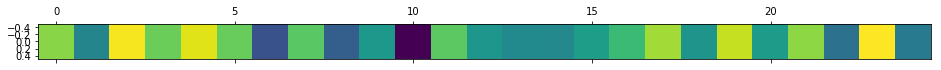

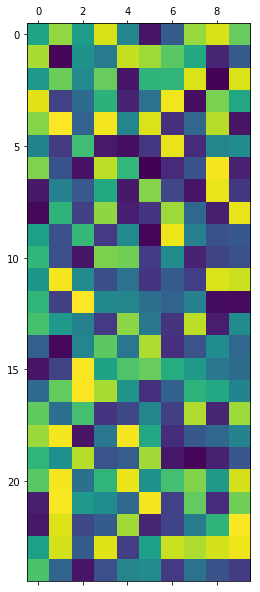

In [34]:
from matplotlib import pyplot as plt
plt.matshow(activations['layer0'])
plt.matshow(weights)
plt.show()

In [35]:
model._modules.items()

odict_items([('0', Linear(in_features=10, out_features=25, bias=True)), ('1', ReLU()), ('2', Linear(in_features=25, out_features=2, bias=True))])

In [69]:
import torch.nn as nn


model = nn.Sequential(
    nn.Linear(10, 25),
    nn.ReLU(),
    nn.Linear(25, 2)
)


visualisation = {}

def hook_fn(m, i, o):
    visualisation[str(m)] = o.detach().numpy()

def get_all_layers(model):
    for name, layer in model._modules.items():
        layer.register_forward_hook(hook_fn)

In [70]:
for param in model.parameters():
    param.requires_grad = False

In [71]:
model.eval()

Sequential(
  (0): Linear(in_features=10, out_features=25, bias=True)
  (1): ReLU()
  (2): Linear(in_features=25, out_features=2, bias=True)
)

In [72]:
get_all_layers(model)

In [73]:
visualisation

{}

In [74]:
out = model(torch.randn(1, 10))

In [75]:
visualisation

{'Linear(in_features=10, out_features=25, bias=True)': array([[ 0.00316985, -0.08310953,  0.54357266,  0.7405807 , -0.16417319,
          0.385947  ,  0.8438901 ,  0.38129696,  0.46040848, -0.11029162,
          0.0388878 , -0.04883998, -0.11077804, -0.1817394 , -0.14541033,
         -0.23613755,  0.32240853, -0.2988292 , -0.11823373,  0.2651435 ,
         -0.7618786 ,  0.5321647 ,  0.12714799,  0.5923781 ,  0.55662835]],
       dtype=float32),
 'ReLU()': array([[0.00316985, 0.        , 0.54357266, 0.7405807 , 0.        ,
         0.385947  , 0.8438901 , 0.38129696, 0.46040848, 0.        ,
         0.0388878 , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.32240853, 0.        , 0.        , 0.2651435 ,
         0.        , 0.5321647 , 0.12714799, 0.5923781 , 0.55662835]],
       dtype=float32),
 'Linear(in_features=25, out_features=2, bias=True)': array([[-0.6169652 ,  0.28780353]], dtype=float32)}

(25,)


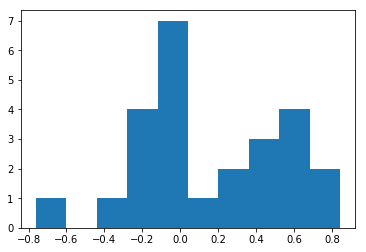

In [76]:
out1 = visualisation['Linear(in_features=10, out_features=25, bias=True)']
out1 = out1.reshape(-1)
print(out1.shape)
plt.hist(out1)
plt.show()